In [1]:
import matplotlib.pyplot as plt
import os
import random
import cv2
import numpy as np
import skimage

In [2]:
data_path = os.path.join(".", "marketing-data")

In [3]:
images = os.listdir(data_path)

In [4]:
sample_path = os.path.join(data_path, random.sample(images,1)[0])
sample_path

'./marketing-data/Sunkist(R) Tangerine.png'

In [5]:
sample_image = plt.imread(sample_path)

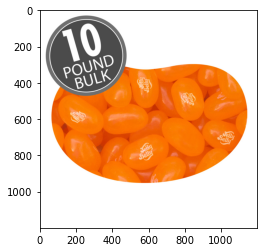

In [6]:
plt.imshow(sample_image)

In [7]:
mask_path = os.path.join(".", "JellyBellyMask.png")

In [8]:
mask_image = plt.imread(mask_path)[:,:,:3]

In [9]:
mask_image.shape

(1200, 1200, 3)

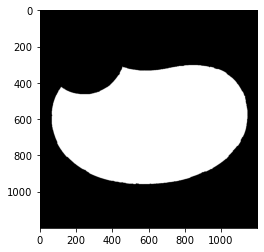

In [10]:
plt.imshow(mask_image)
plt.show()

In [11]:
mask_sample = sample_image*mask_image

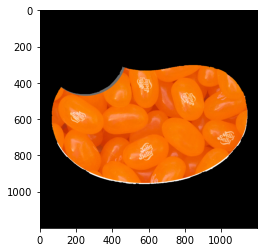

In [12]:
plt.imshow(mask_sample)

In [13]:
from skimage.color import rgb2gray
gray_mask = rgb2gray(mask_image)
gray_mask = cv2.convertScaleAbs(gray_mask*255)

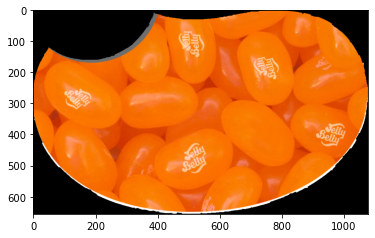

In [14]:
import cv2
## get the minimum bounding rectangle
contours,hierarchy = cv2.findContours(gray_mask,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)

mask_sample_bounded = mask_sample[y:y+h,x:x+w]
mask_sample_bounded.shape
plt.imshow(mask_sample_bounded)

In [15]:
img_og = cv2.convertScaleAbs(mask_sample_bounded*255.0)

In [16]:
mask_sample_bounded_gray = rgb2gray(mask_sample_bounded)

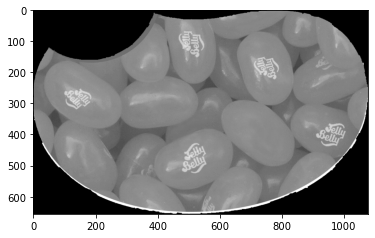

In [17]:
# see the grayscale image
plt.imshow(mask_sample_bounded_gray, "gray")
plt.show()

In [18]:
# otsu import
from skimage.filters import threshold_otsu
# 3-D to 2-D
from skimage.color import rgb2gray, rgb2hsv, rgb2yuv
from scipy import ndimage

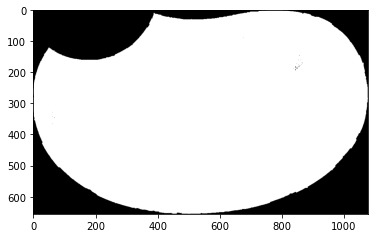

In [19]:
# get the otsu thresholding
img_threshold = threshold_otsu(mask_sample_bounded_gray)
# threshold the image
binary = mask_sample_bounded_gray > img_threshold
# show the image
plt.imshow(binary, "gray")
plt.show()

In [20]:
# fill small holes
# binary_invert_filled = ndimage.binary_fill_holes(binary).astype(int)

In [21]:
# some can be connected with the border
# plt.imshow(binary_invert_filled, "gray")
# plt.show()

In [22]:
# clear the border
from skimage.segmentation import clear_border

In [39]:
# clear the border
clear_border = clear_border(binary)

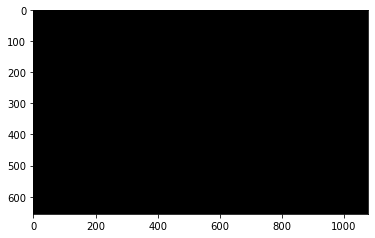

In [41]:
# show the cleared border image
plt.imshow(clear_border, "gray")
plt.show()

In [43]:
clear_border = np.uint8(binary)

In [44]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))

In [45]:
opening = cv2.morphologyEx(clear_border,cv2.MORPH_OPEN,kernel,1)

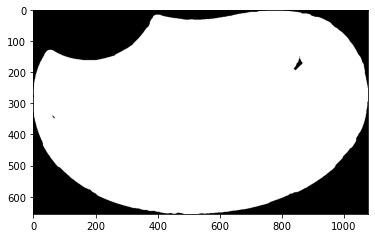

In [46]:
plt.imshow(opening, "gray")

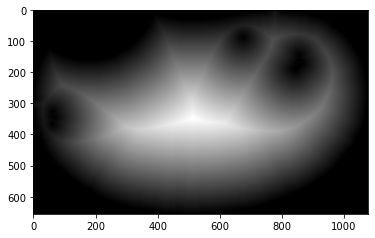

In [47]:
# distance transform
distance = ndimage.distance_transform_edt(binary)

# distance transform image
plt.imshow(distance, "gray")

In [30]:
# distance = distance / np.max(distance)

In [48]:
# need to find a thresholding for this image too
# resort to otsu
img_threshold_distance = threshold_otsu(distance)

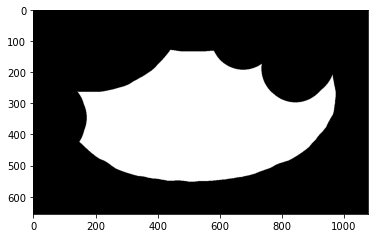

In [49]:
# threshold the image
sure_fg = distance > img_threshold_distance

# see the image
plt.imshow(sure_fg, "gray")

sure_fg = np.uint8(sure_fg)

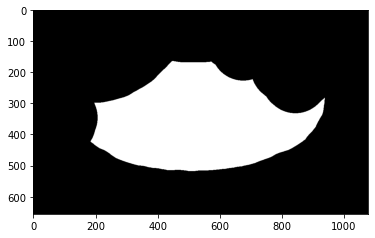

In [50]:
# erosion
from skimage.morphology import binary_erosion

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(70,70))

opening = cv2.morphologyEx(sure_fg,cv2.MORPH_ERODE,kernel,30)
plt.imshow(opening, "gray")

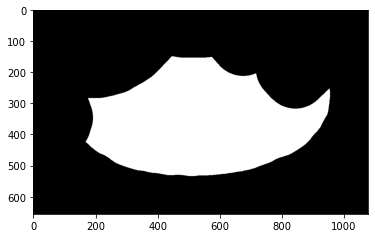

In [51]:
# do the erosion twice to get the sure foreground areas
# erosion once
sure_sure_fg = binary_erosion(sure_fg, cv2.getStructuringElement(cv2.MORPH_CROSS,(20,20))).astype(int)
# erosion twice
sure_sure_fg = binary_erosion(sure_sure_fg, cv2.getStructuringElement(cv2.MORPH_CROSS,(20,20))).astype(int)
# check the sure foreground
plt.imshow(sure_sure_fg, "gray")

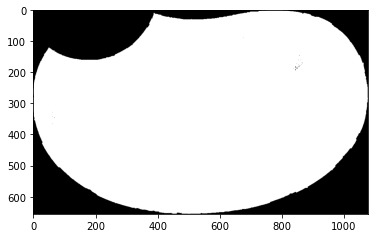

In [52]:
# what is the sure background
sure_bg = clear_border
plt.imshow(sure_bg, "gray")

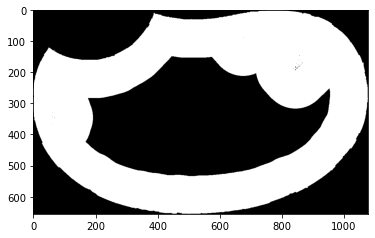

In [61]:
sure_sure_fg = np.uint8(sure_sure_fg)

# unknown part is sure_bg - sure_fg
unknown = cv2.subtract(sure_bg, sure_sure_fg)

# make it uint8 - cv2 quirk
unknown = cv2.convertScaleAbs(unknown*255)

# see the unknown images
plt.imshow(unknown, "gray")

# convert to unint8 again
sure_sure_fg = cv2.convertScaleAbs(sure_sure_fg*255)

In [62]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [63]:
## Where does gray_image come from???

# convert to uint8
gray_image = cv2.convertScaleAbs(gray_image*255)

# make it 3-D
gray_image = np.dstack([gray_image]*3)

# finally watershed
markers = cv2.watershed(gray_image,markers)

# marker 1 has all the masks
binary_markers = markers == 1

# invert
binary_markers = 1 - binary_markers.astype(int)

# convert to uint8
binary_markers = cv2.convertScaleAbs(binary_markers*255)

plt.imshow(binary_markers, "gray")

NameError: name 'gray_image' is not defined

In [ ]:

image_max = ndimage.maximum_filter(mask_sample_bounded_gray, size=60, mode='constant')
plt.imshow(image_max, "gray")

In [ ]:
coordinates = skimage.feature.peak_local_max(mask_sample_bounded_gray, min_distance=60)

In [ ]:
# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(mask_sample_bounded_gray, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(mask_sample_bounded_gray, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [ ]:
fg_mask = np.zeros((image_max.shape[0], image_max.shape[1]))

In [ ]:
coordinates.shape

In [ ]:
coordinates

In [ ]:
for coord in coordinates: 
    fg_mask[coord[0], coord[1]] = 1

In [ ]:
fg_mask = cv2.convertScaleAbs(fg_mask*255.0)

In [ ]:
fg_mask.shape

In [ ]:
fg_mask = np.dstack([fg_mask]*3)

In [ ]:
img = np.zeros((fg_mask.shape[0],fg_mask.shape[1],3), np.uint8)
for coord in coordinates:
    cv2.ellipse(img,(coord[1],coord[0]),(20,20),0,0,360,(255,255,255),-1)
plt.imshow(img)

In [ ]:
overlay = cv2.addWeighted(img_og,0.3,img,0.7,0)
plt.imshow(overlay)
sure_fg = img[:,:,0].copy()

In [ ]:
img = np.zeros((fg_mask.shape[0],fg_mask.shape[1],3), np.uint8)
for coord in coordinates:
    cv2.ellipse(img,(coord[1],coord[0]),(70,70),0,0,360,(255,255,255),-1)
plt.imshow(img)

In [ ]:
# sure_fg = np.uint8(sure_sure_fg)
sure_bg = img[:,:,0]
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, "gray")

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers.shape
markers[unknown==255] = 0
img = cv2.convertScaleAbs(mask_sample_bounded*255.0)
img.shape
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
np.unique(markers)

In [ ]:
from skimage import measure, color, io
img2 = color.label2rgb(markers, bg_label=0)
np.unique(markers)

In [ ]:
# see the image
temp1 = np.zeros((markers.shape[0], markers.shape[1]))
for idx in np.unique(markers):
    if idx not in [1,-1]:
        temp = markers == idx
        temp = cv2.convertScaleAbs(temp*255.0)
        ## get the minimum bounding rectangle
        contours,hierarchy = cv2.findContours(temp,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(temp1, contours, -1, (255,255,255), -1)
#         cnt = contours[0]

#         x,y,w,h = cv2.boundingRect(cnt)

#         mask_sample_bounded = img_og[y:y+h,x:x+w, :]
#         plt.imshow(mask_sample_bounded)
#         plt.show()

plt.imshow(temp1, "gray")

In [ ]:
temp1 = np.dstack([temp1]*3)
temp1 = cv2.convertScaleAbs(temp1*255.0)
overlay = cv2.addWeighted(img_og,0.3,temp1,0.7,0)
plt.imshow(overlay)

In [ ]:
# see the image
for idx in np.unique(markers):
    temp = np.zeros((markers.shape[0], markers.shape[1]))
    if idx not in [1,-1]:
        temp = markers == idx
        temp = cv2.convertScaleAbs(temp*255.0)
        ## get the minimum bounding rectangle
        contours,hierarchy = cv2.findContours(temp,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        cnt = contours[0]

        x,y,w,h = cv2.boundingRect(cnt)

        mask_sample_bounded = img_og[y:y+h,x:x+w, :]
        plt.imshow(mask_sample_bounded)
        plt.show()